In [21]:
import cv2
import numpy as np
from random import shuffle
import random
import tqdm
import os
import tensorflow as tf
import gc
import matplotlib.pyplot as plt
%matplotlib inline

IMAGE_SIZE = [299, 299]
EPOCHS = 15

VALIDATION_SPLIT = 0.20
CLASSES = ['normal', 'pneumonia'] # do not change, maps to the labels in the data (folder names)

In [22]:
train_dir = 'train_data'
test_dir = 'test_data'

train_normal = ['train_data/{}'.format(i) for i in os.listdir(train_dir) if 'NORMAL' in i] #get normal
train_pneumonia = ['train_data/{}'.format(i) for i in os.listdir(train_dir) if 'PNEUMONIA' in i] #get diseased

test_imgs = ['test_data/{}'.format(i) for i in os.listdir(test_dir)] #get test imgs

train_imgs = train_normal + train_pneumonia
random.shuffle(train_imgs)

del train_normal
del train_pneumonia
gc.collect()

7560

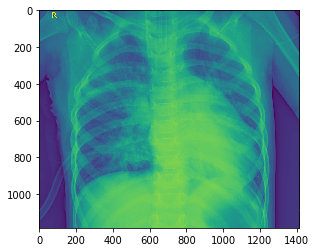

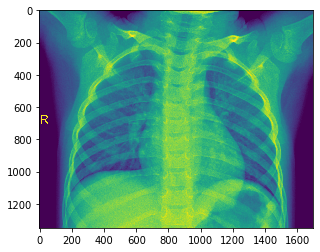

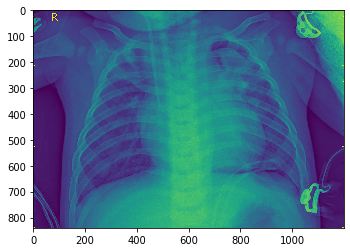

In [23]:
#show some imgs
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    implot=plt.imshow(img)
    plt.show()

In [24]:
#declare img dims
nrows = 256
ncols = 256
channels = 3

def read_and_process_image(list_of_images):
    """
    Returns two arrays:
        X is an array of resized imgs
        y is an array of labels
    """
    X = []
    y = []
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncols), interpolation=cv2.INTER_CUBIC))
        if 'NORMAL' in image:
            y.append(0)
        elif 'PNEUMONIA' in image:
            y.append(1)
            
    return X, y

In [25]:
X, y = read_and_process_image(train_imgs)

In [26]:
#preview X
X[0]

array([[[58, 58, 58],
        [63, 63, 63],
        [64, 64, 64],
        ...,
        [17, 17, 17],
        [17, 17, 17],
        [18, 18, 18]],

       [[58, 58, 58],
        [63, 63, 63],
        [66, 66, 66],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [16, 16, 16]],

       [[59, 59, 59],
        [67, 67, 67],
        [64, 64, 64],
        ...,
        [14, 14, 14],
        [15, 15, 15],
        [14, 14, 14]],

       ...,

       [[35, 35, 35],
        [35, 35, 35],
        [35, 35, 35],
        ...,
        [41, 41, 41],
        [41, 41, 41],
        [41, 41, 41]],

       [[35, 35, 35],
        [35, 35, 35],
        [35, 35, 35],
        ...,
        [42, 42, 42],
        [42, 42, 42],
        [41, 41, 41]],

       [[35, 35, 35],
        [35, 35, 35],
        [35, 35, 35],
        ...,
        [42, 42, 42],
        [42, 42, 42],
        [41, 41, 41]]], dtype=uint8)

In [27]:
#preview Y
y[0:10]

[1, 0, 1, 0, 0, 1, 1, 0, 0, 1]

AttributeError: module 'matplotlib.pyplot' has no attribute 'label'

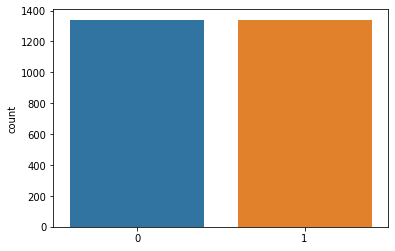

In [28]:
import seaborn as sns
del train_imgs
gc.collect()

#Convert lists
X = np.array(X)
y = np.array(y)

sns.countplot(y)
plt.label('Labels for Normal and Pneumonia')


In [29]:
print("Shape of train images is: ", X.shape)
print("Shape of train labels is: ", y.shape)

Shape of train images is:  (2682, 256, 256, 3)
Shape of train labels is:  (2682,)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.20, random_state=2)

print("Shape of train images is: ", X_train.shape)
print("Shape of test images is: ", X_val.shape)

print("Shape of labels is: ", y_train.shape)
print("Shape of labels is: ", y_val.shape)

Shape of train images is:  (2145, 256, 256, 3)
Shape of test images is:  (537, 256, 256, 3)
Shape of labels is:  (2145,)
Shape of labels is:  (537,)


In [31]:
del X
del y
gc.collect()

ntrain = len(X_train)
nval= len(X_val)

batch_size = 32

In [32]:
from keras.models import  Sequential
from keras.layers import  *
from keras.optimizers import  *
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

In [33]:
pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 147458    
Total params: 21,950,242
Trainable params: 147,458
Non-trainable params: 21,802,784
_________________________________________________________________


In [34]:
train_datagen = ImageDataGenerator(rescale=1./256)
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

test_datagen = ImageDataGenerator(rescale=1./256)
test_generator = test_datagen.flow(X_val, y_val, batch_size=batch_size)

In [35]:
history = model.fit_generator(train_generator, steps_per_epoch=ntrain // batch_size, epochs=EPOCHS, validation_data=test_generator,
                             validation_steps=nval // batch_size)

Epoch 1/10
33/33 [==============================] - 103s 3s/step - loss: 1.4791 - acc: 0.8366 - val_loss: 2.4089 - val_acc: 0.6504
Epoch 2/10
33/33 [==============================] - 100s 3s/step - loss: 0.2338 - acc: 0.9539 - val_loss: 1.5578 - val_acc: 0.7051
Epoch 3/10
33/33 [==============================] - 98s 3s/step - loss: 0.0500 - acc: 0.9827 - val_loss: 1.0851 - val_acc: 0.7520
Epoch 4/10
33/33 [==============================] - 98s 3s/step - loss: 0.0814 - acc: 0.9755 - val_loss: 2.2090 - val_acc: 0.6641
Epoch 5/10
33/33 [==============================] - 97s 3s/step - loss: 0.0276 - acc: 0.9894 - val_loss: 0.8019 - val_acc: 0.8047
Epoch 6/10
33/33 [==============================] - 97s 3s/step - loss: 0.0334 - acc: 0.9877 - val_loss: 0.8466 - val_acc: 0.8145
Epoch 7/10
33/33 [==============================] - 97s 3s/step - loss: 0.0350 - acc: 0.9894 - val_loss: 0.8240 - val_acc: 0.8242
Epoch 8/10
33/33 [==============================] - 94s 3s/step - loss: 0.0218 - acc: 0.

In [36]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

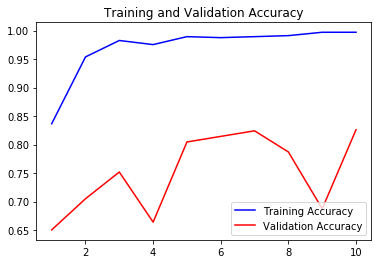

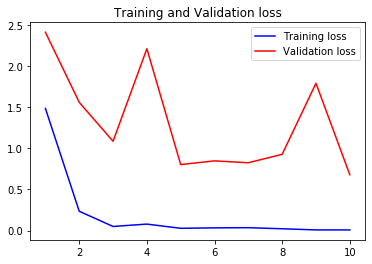

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+ 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [38]:
# FINALLY LETS PREDICT
X_test, y_test = read_and_process_image(test_imgs[0:10])
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./299)

1/1 [==============================] - 0s 50ms/sample
(1, 2)
1/1 [==============================] - 0s 53ms/sample
(1, 2)
1/1 [==============================] - 0s 51ms/sample
(1, 2)
1/1 [==============================] - 0s 52ms/sample
(1, 2)
1/1 [==============================] - 0s 51ms/sample
(1, 2)
1/1 [==============================] - 0s 52ms/sample
(1, 2)
1/1 [==============================] - 0s 58ms/sample
(1, 2)
1/1 [==============================] - 0s 50ms/sample
(1, 2)
1/1 [==============================] - 0s 53ms/sample
(1, 2)
1/1 [==============================] - 0s 52ms/sample
(1, 2)


<Figure size 2160x1440 with 0 Axes>

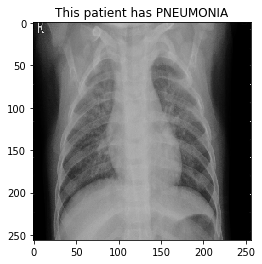

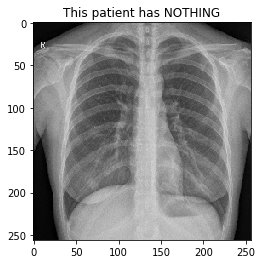

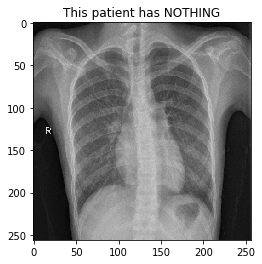

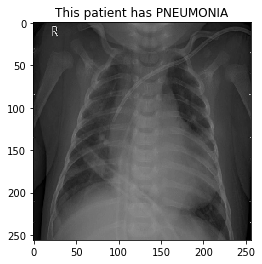

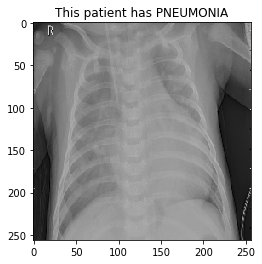

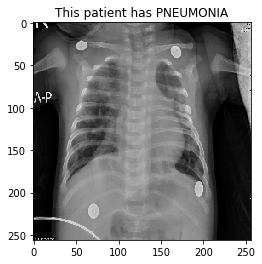

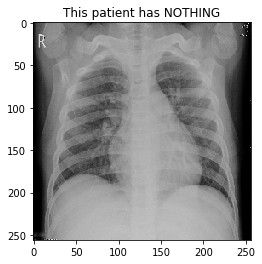

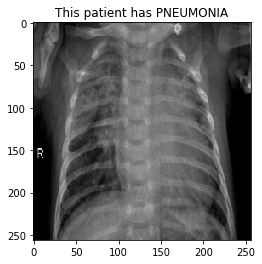

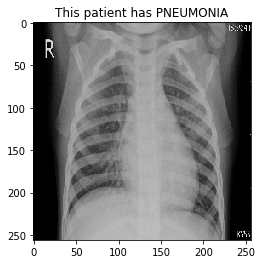

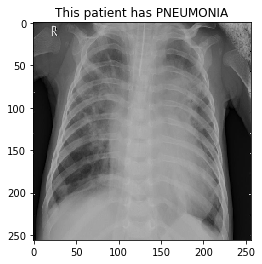

In [48]:
i=0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch,verbose=1)
    print(pred.shape)
    if pred[0][1] > 0.5:
        text_labels.append('PNEUMONIA')
    else:
        text_labels.append('NOTHING')
    plt.subplots(1,1 , 'col')
    plt.title('This patient has '+ text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()